In [1]:
from google.colab import files
uploaded=files.upload()

Saving Emo_Data_polarity.csv to Emo_Data_polarity.csv


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
#from transformers import BertTokenizer
from sklearn.metrics import classification_report

# Load data
Emo_Data_polarity = pd.read_csv('/content/Emo_Data_polarity.csv')

print(Emo_Data_polarity.columns)
print('')
print(Emo_Data_polarity.shape)
print(Emo_Data_polarity.head())
print('')
Emo_Data_polarity.shape

Index(['Text', 'Emotion'], dtype='object')

(118961, 2)
                                                Text   Emotion
0                            i didnt feel humiliated  negative
1  i can go from feeling so hopeless to so damned...  negative
2   im grabbing a minute to post i feel greedy wrong  negative
3  i am ever feeling nostalgic about the fireplac...  positive
4                               i am feeling grouchy  negative



(118961, 2)

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from transformers import BertTokenizer
from sklearn.metrics import classification_report

# Load data
Emo_Data_polarity = pd.read_csv('/content/Emo_Data_polarity.csv')

print(Emo_Data_polarity.columns)
print('')
print(Emo_Data_polarity.shape)
print(Emo_Data_polarity.head())
print('')
Emo_Data_polarity.shape

Index(['Text', 'Emotion'], dtype='object')

(118961, 2)
                                                Text   Emotion
0                            i didnt feel humiliated  negative
1  i can go from feeling so hopeless to so damned...  negative
2   im grabbing a minute to post i feel greedy wrong  negative
3  i am ever feeling nostalgic about the fireplac...  positive
4                               i am feeling grouchy  negative



(118961, 2)

In [4]:
# Replacing intent text values to numerical
Emo_Data_polarity=Emo_Data_polarity.replace({"neutral":0,"negative":1,"positive":2, "ambiguous":3})
Emo_Data_polarity['Emotion'].unique()

array([1, 2, 3, 0])

In [5]:
# Split dataset into train, validation, and test sets
x_train, x_test, y_train, y_test = train_test_split(Emo_Data_polarity["Text"], Emo_Data_polarity["Emotion"],
                                                    test_size=0.1, shuffle=True, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=1)
x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape


((96357,), (10707,), (11897,), (96357,), (10707,), (11897,))

In [6]:
from transformers import DistilBertTokenizer
# Tokenize and pad
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length=170
x_train_pad = tokenizer.batch_encode_plus(x_train.tolist(), return_tensors='np', padding='max_length')
x_val_pad = tokenizer.batch_encode_plus(x_val.tolist(), return_tensors='np', padding='max_length')
x_test_pad = tokenizer.batch_encode_plus(x_test.tolist(), return_tensors='np', padding='max_length')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [7]:
# Convert BatchEncoding to NumPy arrays
x_train_array = {key: x_train_pad[key] for key in x_train_pad}
x_val_array = {key: x_val_pad[key] for key in x_val_pad}


In [8]:
# One-hot-encode classes
n_classes = len(np.unique(y_train))
y_train_np = y_train.values
y_val_np = y_val.values
y_test_np = y_test.values

y_train_enc = tf.keras.utils.to_categorical(y_train_np, n_classes)
y_val_enc = tf.keras.utils.to_categorical(y_val_np, n_classes)
y_test_enc = tf.keras.utils.to_categorical(y_test_np, n_classes)

In [9]:
#datasets check
print(x_val_pad['input_ids'].shape)
print(y_val_enc.shape)
empty_sequences = np.sum(x_val_pad['input_ids'] == 0, axis=1) == 512
print(np.any(empty_sequences))
print(np.any(np.isnan(x_val_pad['input_ids'])))
print(np.any(np.isnan(y_val_enc)))

print(x_train_pad['input_ids'].shape)
print(y_train_enc.shape)
empty_sequences = np.sum(x_train_pad['input_ids'] == 0, axis=1) == 512
print(np.any(empty_sequences))
print(np.any(np.isnan(x_train_pad['input_ids'])))
print(np.any(np.isnan(y_train_enc)))

(10707, 512)
(10707, 4)
False
False
False
(96357, 512)
(96357, 4)
False
False
False


In [10]:
#Create model
from transformers import TFDistilBertForSequenceClassification
model_distilBERT = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
model_distilBERT.summary()

for layer in model_distilBERT.layers[:-1]:
    layer.trainable = False

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_transform.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  66362880  
 inLayer)                                                        
                                                                 
 pre_classifier (Dense)      multiple                  590592    
                                                                 
 classifier (Dense)          multiple                  3076      
                                                                 
 dropout_19 (Dropout)        multiple                  0         
                                                                 
Total params: 66956548 (255.42 MB)
Trainable params: 66956548 (255.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
from tensorflow.keras.callbacks import EarlyStopping

#compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy()
keras_callbacks = [EarlyStopping(monitor='val_loss', patience=5, mode='min', min_delta=0.0001)]
model_distilBERT.compile(optimizer=optimizer, loss=loss, metrics=metric)

In [ ]:
# train model with callbacks.

history = model_distilBERT.fit(x_train_array, y_train_enc, batch_size=8, epochs=10,
                         validation_data=(x_val_array, y_val_enc),
                         callbacks=[keras_callbacks])



Epoch 1/10
 4222/12045 [=========>....................] - ETA: 5:53 - loss: 4.2778 - categorical_accuracy: 0.3549

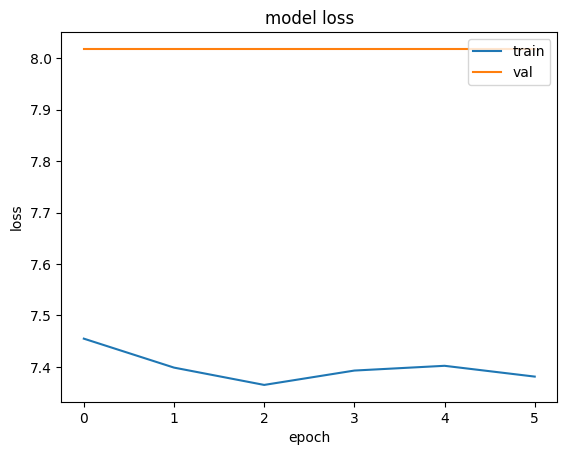

In [39]:
 %matplotlib inline
import matplotlib.pyplot as plt

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [40]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

KeyError: 'accuracy'

In [ ]:
 # Evaluate the model on the test data
score, acc = model_01.evaluate(x_test_pad, y_test_enc, batch_size=32)
print("Test score:", score)
print("Test accuracy:", acc)

361/361 [==============================] - 2s 5ms/step - loss: 6.1611 - accuracy: 0.3543
Test score: 6.161100387573242
Test accuracy: 0.35430407524108887


In [ ]:
# Generate the classification report
y_pred = model_01.predict(x_test_pad)
y_pred = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred))

361/361 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.55      0.56      0.56      1223
           1       0.60      0.56      0.58       524
           2       0.42      0.41      0.42       715
           3       0.27      0.24      0.25       435
           4       0.75      0.73      0.74       337
           5       0.61      0.55      0.58      1236
           6       0.35      0.38      0.37      2411
           7       0.23      0.18      0.21       888
           8       0.09      0.06      0.07       162
           9       0.14      0.09      0.11       149
          10       0.05      0.04      0.04       171
          11       0.52      0.54      0.53       246
          12       0.10      0.12      0.11       242
          13       0.34      0.39      0.36       259
          14       0.04      0.04      0.04       182
          15       0.30      0.36      0.32       499
          16       0.02   